#**Exploratory Data Analysis**

### Setting Up Environment

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from scipy.stats import pointbiserialr
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency
from sklearn.impute import SimpleImputer
plt.rcParams["figure.figsize"] = (15,8)

In [ ]:
application_data_raw = pd.read_csv('application_data.csv', encoding = 'unicode_escape')

In [ ]:
application_data_raw.info()
#application_data_raw.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [ ]:
df = application_data_raw.copy()

### Data Cleaning

In [ ]:
# drop the customer id column
df = df.drop(columns=['SK_ID_CURR'])

# remove invalid values in gender column
df['CODE_GENDER'] = df['CODE_GENDER'].replace("XNA", None)

# drop columns filled >25% with null values
num_missing_values = df.isnull().sum()
nulldf = round(num_missing_values/len(df)*100, 2)
cols_to_keep = nulldf[nulldf<=0.25].index.to_list()
df = df.loc[:, cols_to_keep] # 61 of 121 attributes were removed due to null values.


# impute remaining columns with null values
num_missing_values = df.isnull().sum()
missing_cols = num_missing_values[num_missing_values>0].index.tolist()

for col in missing_cols:
  imp_mean = SimpleImputer(strategy='most_frequent')
  imp_mean.fit(df[[col]])
  df[col] = imp_mean.transform(df[[col]]).ravel()


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 59 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   TARGET                       307511 non-null  int64  
 1   NAME_CONTRACT_TYPE           307511 non-null  object 
 2   CODE_GENDER                  307511 non-null  object 
 3   FLAG_OWN_CAR                 307511 non-null  object 
 4   FLAG_OWN_REALTY              307511 non-null  object 
 5   CNT_CHILDREN                 307511 non-null  int64  
 6   AMT_INCOME_TOTAL             307511 non-null  float64
 7   AMT_CREDIT                   307511 non-null  float64
 8   AMT_ANNUITY                  307511 non-null  float64
 9   AMT_GOODS_PRICE              307511 non-null  float64
 10  NAME_INCOME_TYPE             307511 non-null  object 
 11  NAME_EDUCATION_TYPE          307511 non-null  object 
 12  NAME_FAMILY_STATUS           307511 non-null  object 
 13 

### Data Preprocessing

In [ ]:
continuous_vars = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 
                   'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 
                   'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_2', 'DAYS_LAST_PHONE_CHANGE', 'YEARS_BIRTH', 'YEARS_EMPLOYED']


#categorical_variables = df.select_dtypes(include=["category"]).columns.tolist()
#len(categorical_variables)

categorical_vars = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE','NAME_EDUCATION_TYPE', 
                   'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 
                   'FLAG_EMAIL', 'WEEKDAY_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION', 
                   'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 
                   'ORGANIZATION_TYPE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 
                   'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 
                   'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
                   'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']

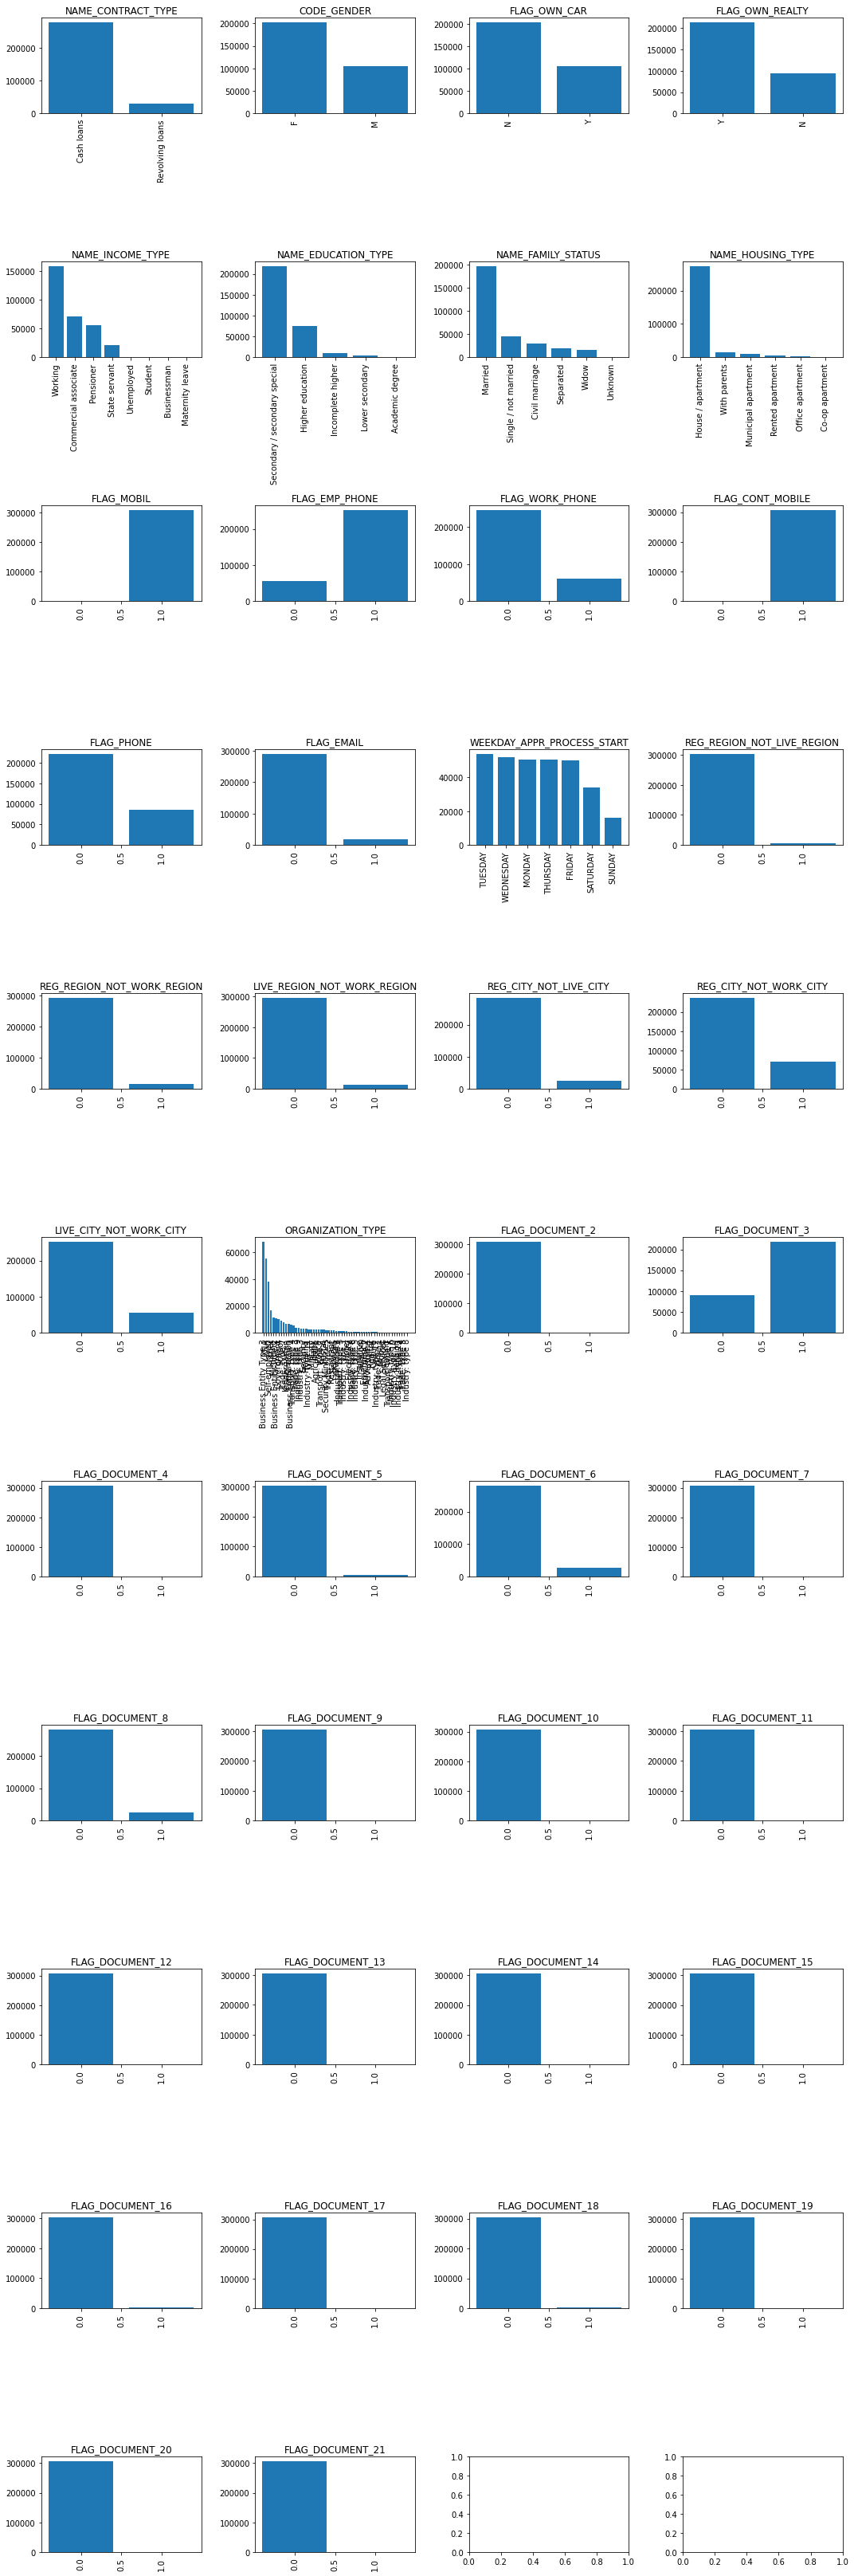

In [ ]:
# plot to see distribution of categorical variables
n_cols = 4
fig, axes = plt.subplots(nrows=int(np.ceil(len(categorical_vars)/n_cols)), 
                         ncols=n_cols, 
                         figsize=(15,45))

for i in range(len(categorical_vars)):
  var = categorical_vars[i]
  dist = df[var].value_counts()
  labels = dist.index
  counts = dist.values
  ax = axes.flatten()[i]
  ax.bar(labels, counts)
  ax.tick_params(axis='x', labelrotation = 90)
  ax.title.set_text(var)


plt.tight_layout()  
plt.show()
# This gives us an idea about which features may already be more useful

In [ ]:
# Remove all FLAG_DOCUMENT features except for FLAG_DOCUMENT_3 as most did not submit, insignificant on model
vars_to_drop = []
vars_to_drop = ["FLAG_DOCUMENT_2"]
vars_to_drop += ["FLAG_DOCUMENT_{}".format(i) for i in range(4,22)]

In [ ]:
# Unit conversions
df['AMT_INCOME_TOTAL'] = df['AMT_INCOME_TOTAL']/100000 # yearly income to be expressed in hundred thousands

df['YEARS_BIRTH'] = round((df['DAYS_BIRTH']*-1)/365).astype('int64') # days of birth changed to years of birth

df['YEARS_EMPLOYED'] = round((df['DAYS_EMPLOYED']*-1)/365).astype('int64') # days employed change to years employed
df.loc[df['YEARS_EMPLOYED']<0, 'YEARS_EMPLOYED'] = 0

df = df.drop(columns=['DAYS_BIRTH', 'DAYS_EMPLOYED'])

In [ ]:
# Encoding categorical variables
def encode_cat(df, var_list):
  for var in var_list:
    df[var] = df[var].astype('category')
    d = dict(zip(df[var], df[var].cat.codes))
    df[var] = df[var].map(d)
    print(var+" Category Codes")
    print(d)
  return df

already_coded = ['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REG_REGION_NOT_LIVE_REGION', 
                 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 
                 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 
                 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 
                 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
                 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']

vars_to_encode = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE','NAME_EDUCATION_TYPE', 
                  'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',  'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE']

for var in already_coded:
  df[var] = df[var].astype('category')

df = encode_cat(df, vars_to_encode)

NAME_CONTRACT_TYPE Category Codes
{'Cash loans': 0, 'Revolving loans': 1}
CODE_GENDER Category Codes
{'M': 1, 'F': 0}
FLAG_OWN_CAR Category Codes
{'N': 0, 'Y': 1}
FLAG_OWN_REALTY Category Codes
{'Y': 1, 'N': 0}
NAME_INCOME_TYPE Category Codes
{'Working': 7, 'State servant': 4, 'Commercial associate': 1, 'Pensioner': 3, 'Unemployed': 6, 'Student': 5, 'Businessman': 0, 'Maternity leave': 2}
NAME_EDUCATION_TYPE Category Codes
{'Secondary / secondary special': 4, 'Higher education': 1, 'Incomplete higher': 2, 'Lower secondary': 3, 'Academic degree': 0}
NAME_FAMILY_STATUS Category Codes
{'Single / not married': 3, 'Married': 1, 'Civil marriage': 0, 'Widow': 5, 'Separated': 2, 'Unknown': 4}
NAME_HOUSING_TYPE Category Codes
{'House / apartment': 1, 'Rented apartment': 4, 'With parents': 5, 'Municipal apartment': 2, 'Office apartment': 3, 'Co-op apartment': 0}
WEEKDAY_APPR_PROCESS_START Category Codes
{'WEDNESDAY': 6, 'MONDAY': 1, 'THURSDAY': 4, 'SUNDAY': 3, 'SATURDAY': 2, 'FRIDAY': 0, 'TUESDA

In [ ]:
# removing rows with all 0
df = df[df.T.any()]

In [ ]:
df.describe()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,EXT_SOURCE_2,DAYS_LAST_PHONE_CHANGE,YEARS_BIRTH,YEARS_EMPLOYED
count,307511.000000,307511.000000,307511.000000,3.075110e+05,307511.000000,3.075110e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,3.075110e+05,307511.000000,307511.000000,307511.000000
mean,0.080729,0.417052,1.687979,5.990260e+05,27107.867258,5.383163e+05,0.020868,-4986.120328,-2994.202373,2.152664,2.052463,2.031521,12.063419,5.139023e-01,-962.855657,43.938646,5.356342
std,0.272419,0.722121,2.371231,4.024908e+05,14493.895950,3.692890e+05,0.013831,3522.886321,1509.450419,0.910679,0.509034,0.502737,3.265832,1.911477e-01,826.808966,11.964047,6.325105
min,0.000000,0.000000,0.256500,4.500000e+04,1615.500000,4.050000e+04,0.000290,-24672.000000,-7197.000000,1.000000,1.000000,1.000000,0.000000,8.173617e-08,-4292.000000,21.000000,0.000000
25%,0.000000,0.000000,1.125000,2.700000e+05,16524.000000,2.385000e+05,0.010006,-7479.500000,-4299.000000,2.000000,2.000000,2.000000,10.000000,3.907824e-01,-1570.000000,34.000000,1.000000
50%,0.000000,0.000000,1.471500,5.135310e+05,24903.000000,4.500000e+05,0.018850,-4504.000000,-3254.000000,2.000000,2.000000,2.000000,12.000000,5.654672e-01,-757.000000,43.000000,3.000000
75%,0.000000,1.000000,2.025000,8.086500e+05,34596.000000,6.795000e+05,0.028663,-2010.000000,-1720.000000,3.000000,2.000000,2.000000,14.000000,6.634218e-01,-274.000000,54.000000,8.000000
max,1.000000,19.000000,1170.000000,4.050000e+06,258025.500000,4.050000e+06,0.072508,0.000000,0.000000,20.000000,3.000000,3.000000,23.000000,8.549997e-01,0.000000,69.000000,49.000000


### Checking for correlations between variables

In [ ]:
X = df.iloc[:, 1:]

In [ ]:
# getting correlation matrix of continuous and categorical variables
cont = ['TARGET'] + continuous_vars
cat = ['TARGET'] + categorical_vars

cont_df = df.loc[:, cont]
cat_df = df.loc[:, cat]

cont_corr = cont_df.corr()
cat_corr = cat_df.corr()

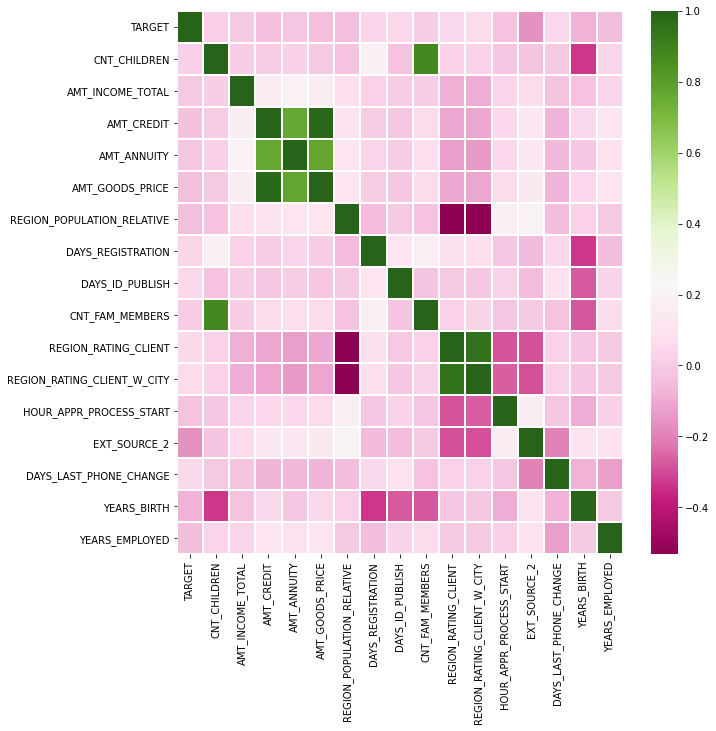

In [ ]:
plt.figure(figsize=(10,10));
sns.heatmap(cont_corr, 
            xticklabels = cont_corr.columns, 
            yticklabels = cont_corr.columns, 
            cmap="PiYG", 
            linewidth = 1);

In [ ]:
# Find Point biserial correlation
for cat_var in categorical_vars:
  for cont_var in  continuous_vars:
    data_cat = df[cat_var].to_numpy()
    data_cont = df[cont_var].to_numpy()
    
    corr, p_val = pointbiserialr(x=data_cat, y=data_cont)
    if np.abs(corr) >= 0.8:
      print(f'Categorical variable: {cat_var}, Continuous variable: {cont_var}, correlation: {corr}')


In [ ]:
# Find Pearson correlation
total_len = len(continuous_vars)
for idx1 in range(total_len-1):
  for idx2 in range(idx1+1, total_len):
    cont_var1 = continuous_vars[idx1]
    cont_var2 = continuous_vars[idx2]
    data_cont1 = X[cont_var1].to_numpy()
    data_cont2 = X[cont_var2].to_numpy()
    corr, p_val = pearsonr(x=data_cont1, y=data_cont2)
    if np.abs(corr) >= 0.8:
      print(f' Continuous var 1: {cont_var1}, Continuous var 2: {cont_var2}, correlation: {corr}')

 Continuous var 1: CNT_CHILDREN, Continuous var 2: CNT_FAM_MEMBERS, correlation: 0.8791602361715272
 Continuous var 1: AMT_CREDIT, Continuous var 2: AMT_GOODS_PRICE, correlation: 0.9867342920601158
 Continuous var 1: REGION_RATING_CLIENT, Continuous var 2: REGION_RATING_CLIENT_W_CITY, correlation: 0.9508422141645037


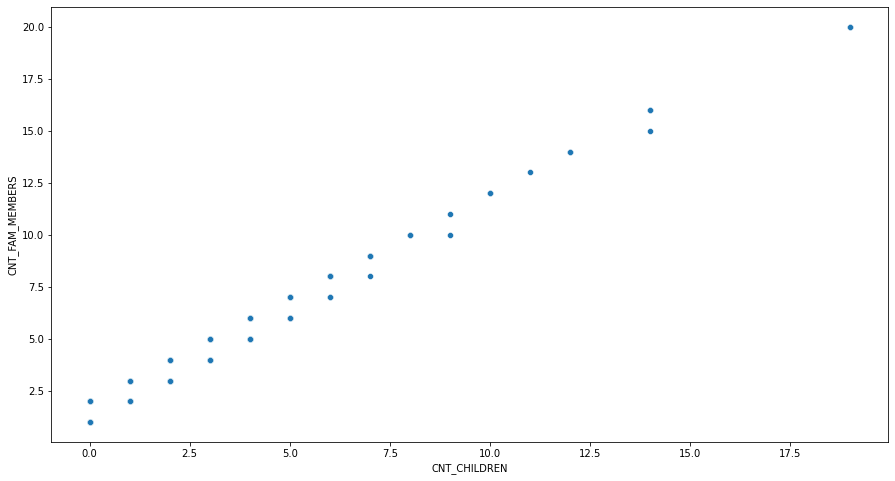

In [ ]:
sns.scatterplot(data=X, x='CNT_CHILDREN',y='CNT_FAM_MEMBERS');

In [ ]:
# Find Cramer's V correlation
total_len = len(categorical_vars)
for idx1 in range(total_len-1):
  for idx2 in range(idx1+1, total_len):
    cat_var1 = categorical_vars[idx1]
    cat_var2 = categorical_vars[idx2]    
    c_matrix = pd.crosstab(X[cat_var1], X[cat_var2])

    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = chi2_contingency(c_matrix)[0]
    n = c_matrix.sum().sum()
    phi2 = chi2/n
    r,k = c_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    corr = np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))
    if corr >= 0.8:
      print(f'categorical variable 1 {cat_var1}, categorical variable 2: {cat_var2}, correlation: {corr}')

categorical variable 1 NAME_INCOME_TYPE, categorical variable 2: FLAG_EMP_PHONE, correlation: 0.9997491034472517
categorical variable 1 FLAG_EMP_PHONE, categorical variable 2: ORGANIZATION_TYPE, correlation: 0.9997768111172551
categorical variable 1 REG_REGION_NOT_WORK_REGION, categorical variable 2: LIVE_REGION_NOT_WORK_REGION, correlation: 0.8605887876340311
categorical variable 1 REG_CITY_NOT_WORK_CITY, categorical variable 2: LIVE_CITY_NOT_WORK_CITY, correlation: 0.8255640362699692


In [ ]:
corr, p_val = pearsonr(x=df['REGION_RATING_CLIENT_W_CITY'], y=df['REGION_RATING_CLIENT'])
print(corr)
# High collinearity of 0.95 between variables suggests that one of it should be removed, we shall remove the REGION_RATING_CLIENT_W_CITY.

0.9508422141645037


In [ ]:
# Drop highly correlated variables
vars_to_drop += ['CNT_FAM_MEMBERS', 'REG_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_WORK_CITY', 'AMT_GOODS_PRICE', 'REGION_RATING_CLIENT_W_CITY']
features_to_keep = [x for x in df.columns if x not in vars_to_drop]

In [ ]:
features_to_keep

['TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REGION_RATING_CLIENT',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_2',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_3',
 'YEARS_BIRTH',
 'YEARS_EMPLOYED']

In [ ]:
new_df = df.loc[:, features_to_keep]
new_df

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,YEARS_BIRTH,YEARS_EMPLOYED
0,1,0,1,0,1,0,2.025,406597.5,24700.5,7,4,3,1,0.018801,-3648.0,-2120,1,1,0,1,1,0,2,6,10,0,0,0,0,5,0.262949,-1134.0,1,26,2
1,0,0,0,0,0,0,2.700,1293502.5,35698.5,4,1,1,1,0.003541,-1186.0,-291,1,1,0,1,1,0,1,1,11,0,0,0,0,39,0.622246,-828.0,1,46,3
2,0,1,1,1,1,0,0.675,135000.0,6750.0,7,4,3,1,0.010032,-4260.0,-2531,1,1,1,1,1,0,2,1,9,0,0,0,0,11,0.555912,-815.0,0,52,1
3,0,0,0,0,1,0,1.350,312682.5,29686.5,7,4,0,1,0.008019,-9833.0,-2437,1,1,0,1,0,0,2,6,17,0,0,0,0,5,0.650442,-617.0,1,52,8
4,0,0,1,0,1,0,1.215,513000.0,21865.5,7,4,3,1,0.028663,-4311.0,-3458,1,1,0,1,0,0,2,4,11,0,0,0,1,37,0.322738,-1106.0,0,55,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,0,1,0,0,0,1.575,254700.0,27558.0,7,4,2,5,0.032561,-8456.0,-1982,1,1,0,1,0,0,1,4,15,0,0,0,0,43,0.681632,-273.0,0,26,1
307507,0,0,0,0,1,0,0.720,269550.0,12001.5,3,4,5,1,0.025164,-4388.0,-4090,1,0,0,1,1,0,2,1,8,0,0,0,0,57,0.115992,0.0,1,57,0
307508,0,0,0,0,1,0,1.530,677664.0,29979.0,7,1,2,1,0.005002,-6737.0,-5150,1,1,0,1,0,1,3,4,9,0,0,0,1,39,0.535722,-1909.0,1,41,22
307509,1,0,0,0,1,0,1.710,370107.0,20205.0,1,4,1,1,0.005313,-2562.0,-931,1,1,0,1,0,0,2,6,9,0,0,1,0,3,0.514163,-322.0,1,33,13


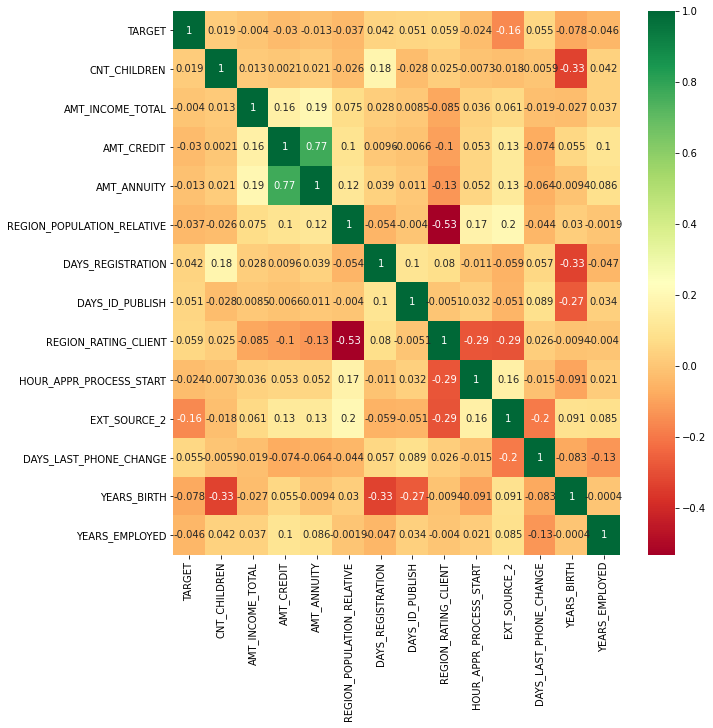

In [ ]:
# Checking correlation of X continuous columns vs TARGET column
plt.figure(figsize=(10,10))
df_corr = new_df.corr()
ax = sns.heatmap(df_corr,
            xticklabels=df_corr.columns,
            yticklabels=df_corr.columns,
            annot = True,
            cmap ="RdYlGn")
# No particular feature found to be significantly correlated with the target

In [ ]:
# REGION_RATING_CLIENT and REGION_POPULATION_RELATIVE have multicollinearity
features_to_keep.remove('REGION_POPULATION_RELATIVE')

In [ ]:
features_to_keep
# These are our final list of features

['TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REGION_RATING_CLIENT',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_2',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_3',
 'YEARS_BIRTH',
 'YEARS_EMPLOYED']

###Plots

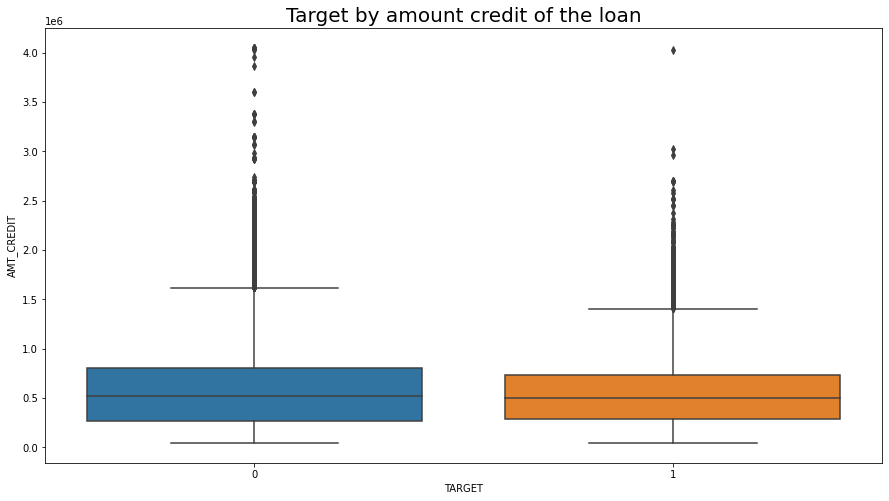

In [ ]:
ax1 = sns.boxplot(y='AMT_CREDIT', x= 'TARGET', data=new_df)
ax1.set_title("Target by amount credit of the loan", fontsize=20);

The amount credit of an individual does not seem to have a siginifcant effect on whether a person finds it difficult to pay. But they are crucial for our business reccomendations so we keep them.

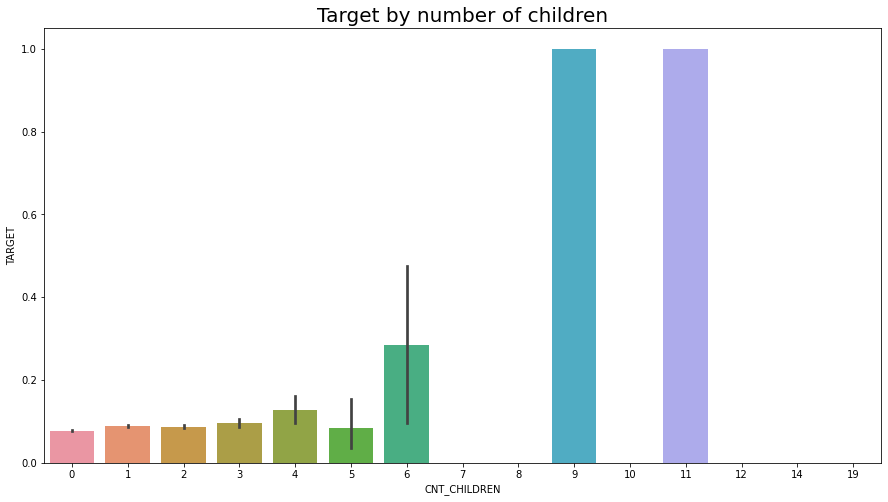

In [ ]:
ax2 = sns.barplot(x='CNT_CHILDREN', y= 'TARGET', data=new_df)
ax2.set_title("Target by number of children", fontsize=20);

From these plots, we can see that number of children has quite a significant effect on whether one defaults or not, with an increasing number of children proving more difficulty to return the loan.

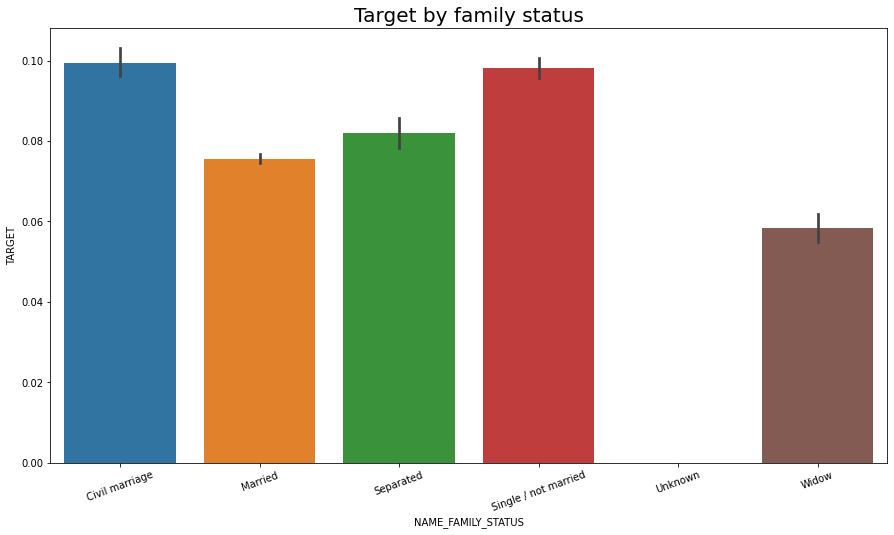

In [ ]:
ax3 = sns.barplot(x='NAME_FAMILY_STATUS', y= 'TARGET', data=new_df);
ax3.set_title("Target by family status", fontsize=20);
plt.xticks(np.arange(6), ['Civil marriage', 'Married', 'Separated', 'Single / not married',
       'Unknown', 'Widow'], rotation=20);


Widows have the lowest likelihood of finding it difficult to pay, a possible target for our reccomendation strategy.

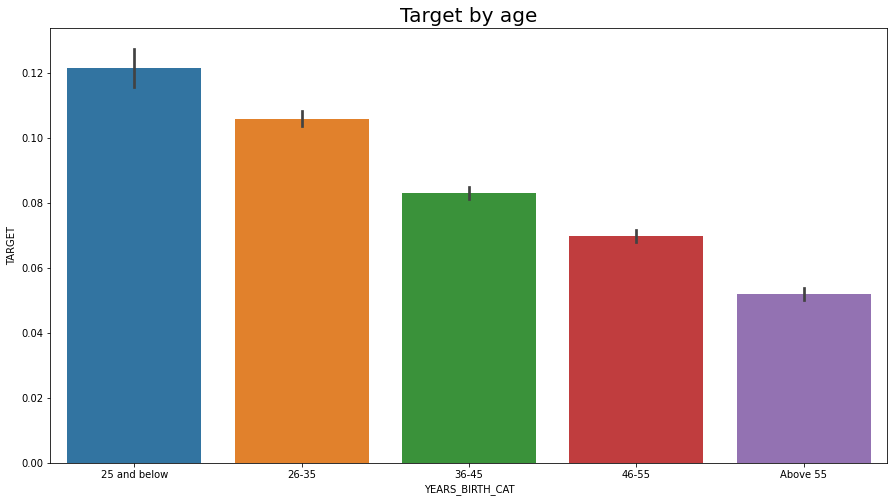

In [ ]:
new_df['YEARS_BIRTH_CAT'] = pd.cut(df.YEARS_BIRTH, bins= [21, 25, 35, 45, 55, 69], labels= ["25 and below", "26-35", "36-45", "46-55", "Above 55"])

ax4 = sns.barplot(x='YEARS_BIRTH_CAT', y= 'TARGET', data=new_df);
ax4.set_title("Target by age", fontsize=20);


Analysis of age groups on ability to pay shows clear trend that the older you are, the better able you are to pay your loans. We will use this to craft our reccomendations.

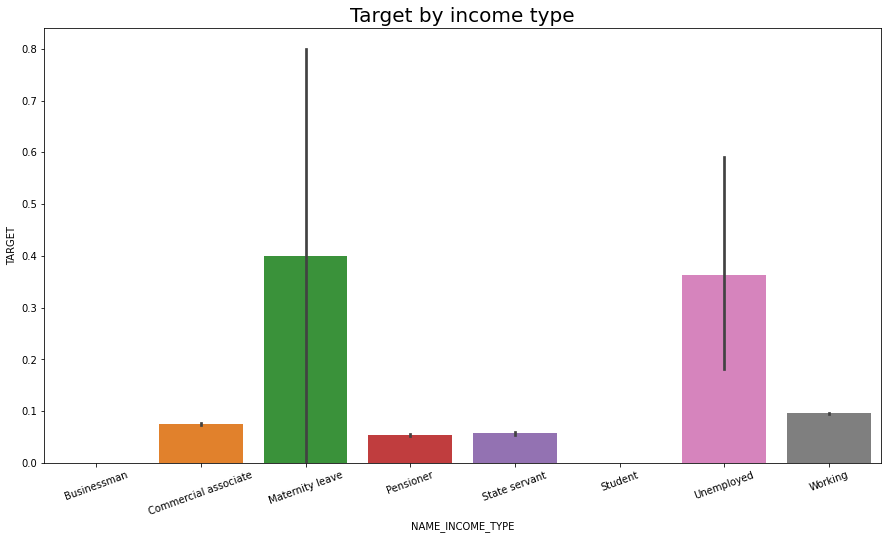

In [ ]:
ax5 = sns.barplot(y='TARGET', x= 'NAME_INCOME_TYPE', data=new_df);
ax5.set_title("Target by income type", fontsize=20);
plt.xticks(np.arange(0, 8),['Businessman', 'Commercial associate', 'Maternity leave', 'Pensioner',
       'State servant', 'Student', 'Unemployed', 'Working'], rotation=20);

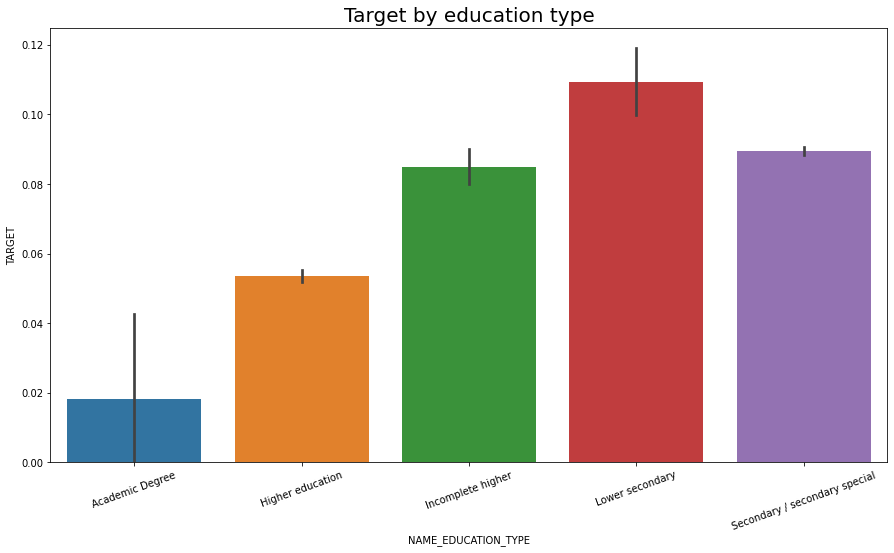

In [ ]:
ax6 = sns.barplot(x='NAME_EDUCATION_TYPE', y= 'TARGET', data=new_df);
ax6.set_title("Target by education type", fontsize=20);
plt.xticks(np.arange(5), ['Academic Degree', 'Higher education', 'Incomplete higher', 'Lower secondary', 'Secondary / secondary special'], rotation=20);

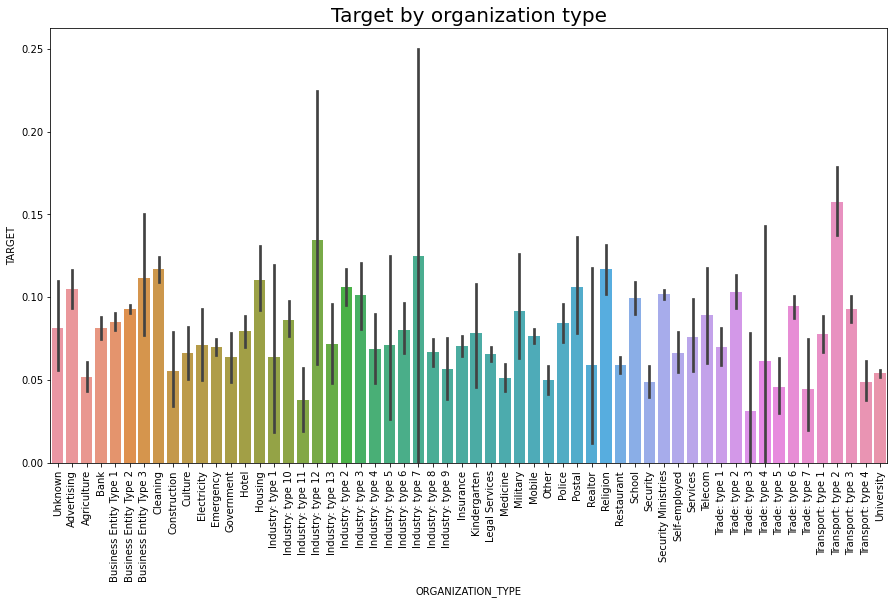

In [ ]:
ax7 = sns.barplot(x='ORGANIZATION_TYPE', y= 'TARGET', data=new_df);
ax7.set_title("Target by organization type", fontsize=20);
plt.xticks(np.arange(58), ['Unknown','Advertising','Agriculture', 'Bank', 'Business Entity Type 1', 'Business Entity Type 2', 
'Business Entity Type 3', 'Cleaning', 'Construction', 'Culture', 'Electricity', 'Emergency', 'Government', 'Hotel', 'Housing',  'Industry: type 1', 'Industry: type 10', 'Industry: type 11', 'Industry: type 12', 'Industry: type 13', 'Industry: type 2', 'Industry: type 3', 'Industry: type 4', 'Industry: type 5',  'Industry: type 6', 'Industry: type 7',  'Industry: type 8',  'Industry: type 9', 'Insurance', 'Kindergarten', 'Legal Services', 'Medicine', 'Military', 'Mobile', 'Other', 'Police', 'Postal', 'Realtor', 'Religion',  'Restaurant', 'School', 'Security', 'Security Ministries', 'Self-employed', 'Services', 'Telecom', 'Trade: type 1', 'Trade: type 2', 'Trade: type 3', 'Trade: type 4', 'Trade: type 5', 'Trade: type 6', 'Trade: type 7', 'Transport: type 1', 'Transport: type 2', 'Transport: type 3', 'Transport: type 4','University'], rotation=90);

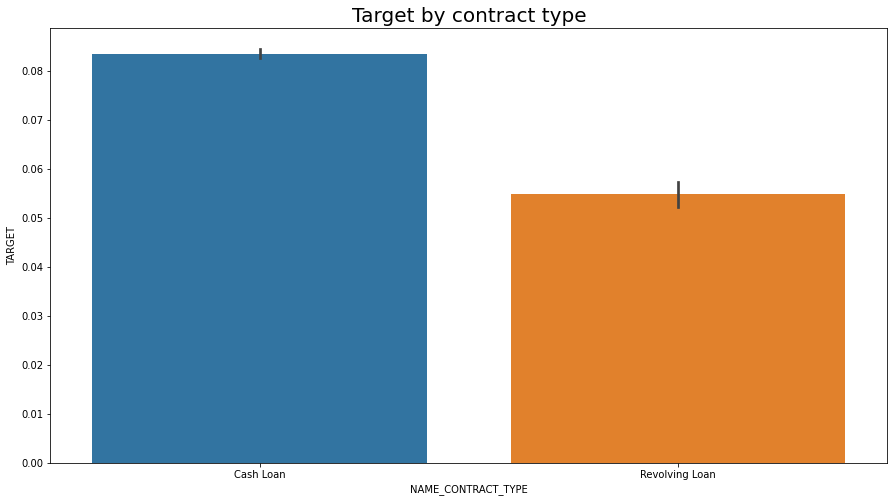

In [ ]:
ax8 = sns.barplot(x='NAME_CONTRACT_TYPE', y= 'TARGET', data=new_df);
ax8.set_title("Target by contract type", fontsize=20);
plt.xticks(np.arange(2), ['Cash Loan', 'Revolving Loan']);

People who get revolving loans are more likely to pay back their loans than cash loans, perhaps due to the revolving loans being of a lower amount, and also its higher interest rate and recurring nature.

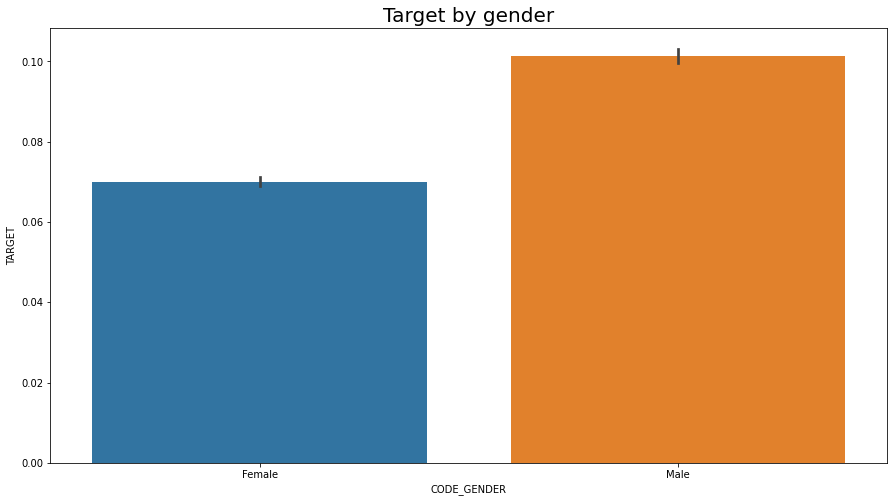

In [ ]:
ax9 = sns.barplot(x='CODE_GENDER', y= 'TARGET', data=new_df);
ax9.set_title("Target by gender", fontsize=20);
plt.xticks(np.arange(2), ['Female', 'Male']);

Males find it harder to pay back their loans than females in general.




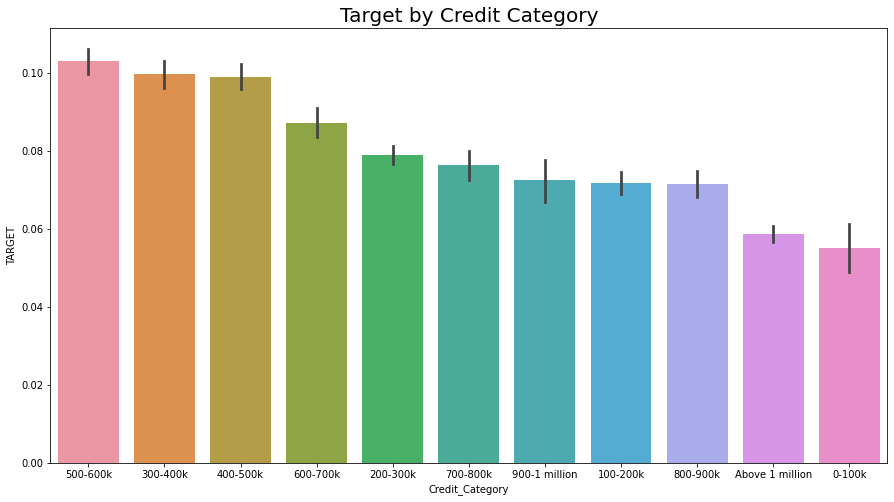

0-100k              5673
100-200k           27981
200-300k           50492
300-400k           23715
400-500k           28867
500-600k           30709
600-700k           21952
700-800k           17727
800-900k           20237
900-1 million       8280
Above 1 million    47053
Name: Credit_Category, dtype: int64
0-100k              331
100-200k           2159
200-300k           4321
300-400k           2623
400-500k           3171
500-600k           3523
600-700k           2097
700-800k           1466
800-900k           1555
900-1 million       647
Above 1 million    2932
Name: Credit_Category, dtype: int64


0-100k              6004
100-200k           30140
200-300k           54813
300-400k           26338
400-500k           32038
500-600k           34232
600-700k           24049
700-800k           19193
800-900k           21792
900-1 million       8927
Above 1 million    49985
Name: Credit_Category, dtype: int64

In [ ]:
# Splitting Credit into bins of 10k
new_df['Credit_Category'] = pd.cut(new_df.AMT_CREDIT, bins= [0, 100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000, 4.050000e+06], labels= ["0-100k", "100-200k", "200-300k", "300-400k", "400-500k", "500-600k", "600-700k", "700-800k", "800-900k","900-1 million", "Above 1 million"])
setorder= new_df.groupby('Credit_Category')['TARGET'].mean().sort_values(ascending=False)
ax10 = sns.barplot(x='Credit_Category', y= 'TARGET', data=new_df, order = setorder.index);
ax10.set_title("Target by Credit Category", fontsize=20);
plt.show()



#No. of people who default
print(new_df.loc[new_df["TARGET"]==0, 'Credit_Category',].value_counts().sort_index())

#No. of people who repayed
print(new_df.loc[new_df["TARGET"]==1, 'Credit_Category',].value_counts().sort_index())

new_df['Credit_Category'].value_counts().sort_index()
# This will be useful for our first recommendation


#temp = new_df["Credit_Category"].value_counts()
#df1 = pd.DataFrame({"Credit_Category": temp.index,'Number of contracts': temp.values})

## Calculate the percentage of target=1 per category value
#cat_perc = new_df[["Credit_Category", 'TARGET']].groupby(["Credit_Category"],as_index=False).mean()
#cat_perc["TARGET"] = cat_perc["TARGET"]*100
#cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)

#fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
        
#s = sns.countplot(ax=ax1, 
#                    x = "Credit_Category", 
#                    data=new_df,
#                    hue ="TARGET",
#                    order=cat_perc["Credit_Category"],
#                    palette=['g','r'])
    

#ax1.set_title("Credit Category", fontdict={'fontsize' : 10, 'fontweight' : 3, 'color' : 'Blue'}) 
#ax1.legend(['Repayer','Defaulter'])
    
## If the plot is not readable, use the log scale.
##if ylog:
##   ax1.set_yscale('log')
##   ax1.set_ylabel("Count (log)",fontdict={'fontsize' : 10, 'fontweight' : 3, 'color' : 'Blue'})   
    
#s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
#s = sns.barplot(ax=ax2, x = "Credit_Category", y='TARGET', order=cat_perc["Credit_Category"], data=cat_perc, palette='Set2')
    
#s.set_xticklabels(s.get_xticklabels(),rotation=90)
#plt.ylabel('Percent of Defaulters [%]', fontsize=10)
#plt.tick_params(axis='both', which='major', labelsize=10)
#ax2.set_title("Credit Category" + " Defaulter %", fontdict={'fontsize' : 15, 'fontweight' : 5, 'color' : 'Blue'}) 

#plt.show();


In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Data columns (total 37 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   TARGET                       307511 non-null  int64   
 1   NAME_CONTRACT_TYPE           307511 non-null  category
 2   CODE_GENDER                  307511 non-null  category
 3   FLAG_OWN_CAR                 307511 non-null  category
 4   FLAG_OWN_REALTY              307511 non-null  category
 5   CNT_CHILDREN                 307511 non-null  int64   
 6   AMT_INCOME_TOTAL             307511 non-null  float64 
 7   AMT_CREDIT                   307511 non-null  float64 
 8   AMT_ANNUITY                  307511 non-null  float64 
 9   NAME_INCOME_TYPE             307511 non-null  category
 10  NAME_EDUCATION_TYPE          307511 non-null  category
 11  NAME_FAMILY_STATUS           307511 non-null  category
 12  NAME_HOUSING_TYPE            307511 non-null